In [1]:
import numpy as np
import pandas as pd 
import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt

['ids-2019', 'forex-eurusd']


In [2]:
def pred_to_binary(s, mean=0.5):
    ss = s.copy()
    ss[s < mean] = 0
    ss[s >= mean] = 1
    return ss

In [3]:
def all_session_off(df):
    ls = []
    for i in range(2,df.shape[0]):
        if df.at[i,"Close"]==df.at[i-1,"Close"] and df.at[i,"Close"]==df.at[i-2,"Close"]:
            ls.append(i)
    return ls

In [4]:
def refilled_prediction(prediction,offs_index):    
    res = []
    i_p = 0
    for i,is_off in enumerate(offs_index):
        if is_off:
            res.append(0)
        else:
            res.append(predictions[i_p])
            i_p+=1
    return res

In [5]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [6]:
# train = pd.read_csv("../input/forex-eurusd/Train_small.csv")
train =  pd.read_csv("../input/ids-2019/Train_full.csv")

In [7]:
# Get data when all sessions are nonactive (all session off)
# Called this "flat" train 
offs = all_session_off(train)
flat_train = train.loc[offs]

# Get "real" data that we can use to train
flat_train_index = train.index.isin(offs)
real_train = train.loc[~flat_train_index]

print(f"{flat_train.shape[0]+real_train.shape[0]}=={train.shape[0]}")
print(f"{flat_train.shape[0]/train.shape[0]}")
print(f"{real_train.shape[0]/train.shape[0]}")

real_train = real_train.reset_index(drop=True)
real_train.head()

709314==709314
0.28650216970199377
0.7134978302980063


,Unnamed: 0,Open,High,Low,Close,Volume,body,upper_tail,lower_tail,SMA_50,SMA_20,ATR,CCI,SAR,hour,min,dayofweek,JPY,AUD,EUR,GBP,USD,lag_return_1,return_2,lag_return_2,return_3,lag_return_3,return_4,lag_return_4,return_5,lag_return_5,return_6,lag_return_6,return_7,lag_return_7,return_8,lag_return_8,return_9,lag_return_9,return_10,...,lag_return_77,return_78,lag_return_78,return_79,lag_return_79,return_80,lag_return_80,return_81,lag_return_81,return_82,lag_return_82,return_83,lag_return_83,return_84,lag_return_84,return_85,lag_return_85,return_86,lag_return_86,return_87,lag_return_87,return_88,lag_return_88,return_89,lag_return_89,return_90,lag_return_90,return_91,lag_return_91,return_92,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,up_down
0,0,1.45865,1.45885,1.45856,1.45873,5004.3375,0.8,1.2,0.9,1.459251,1.459150,0.000489,-76.067241,1.459715,8,5,1,1,0,1,1,0,0.000130,0.000137,-0.000123,0.000014,0.000041,0.000055,0.000055,0.000110,-0.000384,-0.000274,0.000055,-0.000219,-0.000288,-0.000507,-0.000007,-0.000514,0.000274,-0.000240,...,0.000062,0.000665,0.000055,0.000720,-0.000110,0.000610,0.000048,0.000659,-0.000027,0.000631,0.000007,0.000638,0.000027,0.000665,-0.000117,0.000549,0.000055,0.000604,0.000014,0.000617,-0.000514,0.000103,-0.000048,0.000055,-0.000644,-0.000589,0.000048,-0.000541,0.000103,-0.000439,-0.000089,-0.000528,0.000027,-0.000500,-0.000103,-0.000603,0.000226,-0.000377,0.000933,0
1,1,1.45883,1.45883,1.45847,1.45863,4649.9000,-2.0,0.0,1.6,1.459236,1.459130,0.000486,-80.130826,1.459650,8,10,1,1,0,1,1,0,0.000007,-0.000062,0.000130,0.000069,-0.000123,-0.000055,0.000041,-0.000014,0.000055,0.000041,-0.000384,-0.000343,0.000055,-0.000288,-0.000288,-0.000576,-0.000007,-0.000582,...,0.000027,0.000535,0.000062,0.000597,0.000055,0.000652,-0.000110,0.000542,0.000048,0.000590,-0.000027,0.000562,0.000007,0.000569,0.000027,0.000597,-0.000117,0.000480,0.000055,0.000535,0.000014,0.000549,-0.000514,0.000034,-0.000048,-0.000014,-0.000644,-0.000658,0.000048,-0.000610,0.000103,-0.000507,-0.000089,-0.000596,0.000027,-0.000569,-0.000103,-0.000671,0.000226,1
2,2,1.45863,1.45896,1.45845,1.45886,5283.9500,2.3,1.0,1.8,1.459217,1.459097,0.000487,-56.856415,1.459588,8,15,1,1,0,1,1,0,-0.000069,0.000089,0.000007,0.000096,0.000130,0.000226,-0.000123,0.000103,0.000041,0.000144,0.000055,0.000199,-0.000384,-0.000185,0.000055,-0.000130,-0.000288,-0.000418,...,-0.000192,0.000665,0.000027,0.000693,0.000062,0.000755,0.000055,0.000810,-0.000110,0.000700,0.000048,0.000748,-0.000027,0.000720,0.000007,0.000727,0.000027,0.000755,-0.000117,0.000638,0.000055,0.000693,0.000014,0.000707,-0.000514,0.000192,-0.000048,0.000144,-0.000644,-0.000500,0.000048,-0.000452,0.000103,-0.000349,-0.000089,-0.000439,0.000027,-0.000411,-0.000103,1
3,3,1.45865,1.45905,1.45842,1.45895,5370.3375,3.0,1.0,2.3,1.459204,1.459044,0.000490,-44.709738,1.459528,8,20,1,1,0,1,1,0,0.000158,0.000219,-0.000069,0.000151,0.000007,0.000158,0.000130,0.000288,-0.000123,0.000165,0.000041,0.000206,0.000055,0.000261,-0.000384,-0.000123,0.000055,-0.000069,...,0.000062,0.000919,-0.000192,0.000727,0.000027,0.000755,0.000062,0.000816,0.000055,0.000871,-0.000110,0.000761,0.000048,0.000809,-0.000027,0.000782,0.000007,0.000789,0.000027,0.000816,-0.000117,0.000700,0.000055,0.000755,0.000014,0.000768,-0.000514,0.000254,-0.000048,0.000206,-0.000644,-0.000438,0.000048,-0.000391,0.000103,-0.000288,-0.000089,-0.000377,0.000027,0
4,4,1.45902,1.45905,1.45857,1.45887,3738.9375,-1.5,0.3,3.0,1.459187,1.458988,0.000490,-35.872884,1.459471,8,25,1,1,0,1,1,0,0.000062,0.000007,0.000158,0.000165,-0.000069,0.000096,0.000007,0.000103,0.000130,0.000233,-0.000123,0.000110,0.000041,0.000151,0.000055,0.000206,-0.000384,-0.000178,...,0.000343,0.000803,0.000062,0.000864,-0.000192,0.000672,0.000027,0.000700,0.000062,0.000761,0.000055,0.000816,-0.000110,0.000707,0.000048,0.000755,-0.000027,0.000727,0.000007,0.000734,0.000027,0.000761,-0.000117,0.000645,0.000055,0.000700,0.000

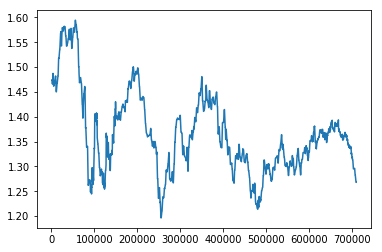

In [8]:
plt.plot(flat_train["Close"])

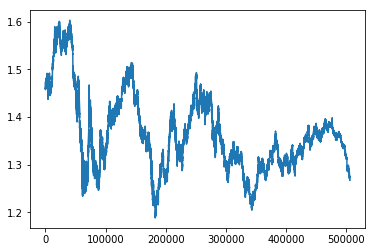

In [9]:
plt.plot(real_train["Close"])

In [10]:
# Get features
features = ["Volume", "body",  "return_2", "return_3", "return_4"]
features

['Volume', 'body', 'return_2', 'return_3', 'return_4']

In [11]:
# Seperate dataset into input and output
X = real_train[features]
y = real_train["up_down"]
X.head()

,Volume,body,return_2,return_3,return_4
0,5004.3375,0.8,0.000137,0.000014,0.000055
1,4649.9000,-2.0,-0.000062,0.000069,-0.000055
2,5283.9500,2.3,0.000089,0.000096,0.000226
3,5370.3375,3.0,0.000219,0.000151,0.000158
4,3738.9375,-1.5,0.000007,0.000165,0.000096


In [12]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: up_down, dtype: int64

In [13]:
# Seperate into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1123)

In [14]:
# Import model
from sklearn.neural_network import MLPClassifier

In [15]:
clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000, verbose=1, early_stopping=True)  
clf.fit(X_train, y_train)

Iteration 1, loss = 1.57662745
Validation score: 0.506060
Iteration 2, loss = 1.22249185
Validation score: 0.525229
Iteration 3, loss = 1.00595638
Validation score: 0.508980
Iteration 4, loss = 0.89774670
Validation score: 0.494618
Iteration 5, loss = 0.88287081
Validation score: 0.518093
Iteration 6, loss = 0.79545012
Validation score: 0.519154
Iteration 7, loss = 0.78907285
Validation score: 0.511133
Iteration 8, loss = 0.75539623
Validation score: 0.520157
Iteration 9, loss = 0.73180974
Validation score: 0.510189
Iteration 10, loss = 0.72849230
Validation score: 0.512430
Iteration 11, loss = 0.71925859
Validation score: 0.495178
Iteration 12, loss = 0.71025357
Validation score: 0.513757
Iteration 13, loss = 0.71533946
Validation score: 0.518063
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [16]:
# Score on train-test 
from sklearn.metrics import r2_score
predictions = clf.predict(X_test)
r2_score(predictions, y_test)

-0.9049340500936105

In [17]:
pd.DataFrame(pred_to_binary(predictions)).describe()

,0
count,167012.000000
mean,0.528016
std,0.499216
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [18]:
# Write to public dataset
test =  pd.read_csv("../input/ids-2019/Test_small_features.csv")

# Get data of nonactive sessions
offs_test = all_session_off(test)
flat_test = test.loc[offs_test]

# Get data of active sessions
flat_test_index = test.index.isin(offs_test)
real_test = test.loc[~flat_test_index]

# Get X on public dataset
X_of_public_test = real_test[features]

# Predict using our model
real_predictions = clf.predict(X_of_public_test)
real_predictions

array([1, 0, 1, ..., 0, 1, 1])

In [19]:
# Merge the prediction in active sessions 
# with array of 0 in nonactive sessions (off sessiosn)
final_predictions = refilled_prediction(real_predictions, flat_test_index)
print(f"{final_predictions[:23]} {len(final_predictions)}")

[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1] 10962


In [20]:
# Write final prediction to file
f = open("submission.csv","w")
f.write("num,\tlabel\n")

for i,u in enumerate(final_predictions[1:]+[0]):
    f.write(f"{i},\t{u}\n")
    
f.close()
!ls

__notebook__.ipynb  __output__.json  submission.csv


In [21]:
# Export submission file
create_download_link(filename='submission.csv')

In [22]:
# Export model
import pickle
pickle.dump(clf, open("model_pickle", 'wb'))
create_download_link(filename='model_pickle')

In [23]:
# Pseudo score on public dataset
def to_binary(s):
    ss = s.copy()
    # If before - later < 0 -> should buy    
    ss[s > 0] = 0
    ss[s < 0] = 1
    return ss

def to_diff(s):
    ss = s.diff(periods=-1)
    # Replace the nan last one with average
    ss = ss.replace(np.nan, ss.mean())
    return ss

from sklearn.metrics import accuracy_score
test["up_down"] = to_binary(to_diff(test["Close"]))

public = test["up_down"]
print(f"Public dataset score = {accuracy_score(public[0:-1],final_predictions[1:])}")
print(f"Public dataset score = {accuracy_score(public[1:],final_predictions[1:])}")
print(f"Public dataset score = {accuracy_score(public[0:-1],final_predictions[0:-1])}")
print(f"Public dataset score = {accuracy_score(public[1:],final_predictions[0:-1])}")
print(f"Public dataset score = {accuracy_score(public,final_predictions[0:-1]+[0])}")
print(f"Public dataset score = {accuracy_score(public,final_predictions[1:]+[0])}")

Public dataset score = 0.6322415837970988
Public dataset score = 0.6361645835234011
Public dataset score = 0.6361645835234011
Public dataset score = 0.6238481890338473
Public dataset score = 0.6361977741288086
Public dataset score = 0.6322751322751323
